In [32]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline_imb

from sklearn.metrics import classification_report                # Performance accuracy, f1-score
from sklearn.metrics import roc_auc_score                        # performance en utilisant la courbe ROC et le score AUC
from sklearn.metrics import log_loss                             # Perte logarithmique
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score, recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

# Clusterisation des coordonnées gps
from sklearn.cluster import KMeans
import folium

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

# Chemins d'accès aux données
repDataConsolidees = '../../data/processed/'
repModels = '../../models/'

# Liste des fichiers usagers disponibles
!pwd
!ls {repDataConsolidees}*  -lrt
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)


/Users/stephane/Documents/Professionnel/Formation/Certificats/Datascientest/4 - Projet AccidentsRoutiers/git/JAN24_CDS_Accidents/notebooks/2 - Modélisation
ls: -lrt: No such file or directory
../../data/processed/X_test_preprocessed.csv
../../data/processed/X_train_preprocessed.csv
../../data/processed/agg_accidents.csv
../../data/processed/agg_usagers.csv
../../data/processed/test_set.csv
../../data/processed/test_stat.csv
../../data/processed/test_stat_agrege.csv
../../data/processed/test_train.csv
../../data/processed/train_set.csv
../../data/processed/usagers.csv
../../data/processed/y_test_binary_preprocessed-save.csv
../../data/processed/y_test_binary_preprocessed.csv
../../data/processed/y_test_preprocessed.csv
../../data/processed/y_train_binary_preprocessed-save.csv
../../data/processed/y_train_binary_preprocessed.csv
../../data/processed/y_train_preprocessed.csv


In [33]:
# ETAPE 1 - Chgt des données 
train = pd.read_csv (repDataConsolidees + "train_set.csv", dtype={'user_actp' : str}, ) 
train.describe()

# Suppression des enregistrements sans valeur cible
train = train[train.user_gravite != -1]

feature = train.drop("user_gravite", axis=1)
target = train['user_gravite']

test = pd.read_csv (repDataConsolidees + "test_set.csv", dtype={'user_actp' : str}, ) 
test.describe()

test_feature = test.drop("user_gravite", axis=1)
test_target = test['user_gravite']

# Chgt du résultat des tests statistique de l'étape précédente : ces infos serviront à définir à éliminer une variable sur un seuil ou à la conserver
test_stat = pd.read_csv(repDataConsolidees + "test_stat_agrege.csv")



In [34]:
# Génération d'un df de test des Fonctions de Transformation
testTrain = train.head(20)
save_testTrain = testTrain.copy()


In [35]:
testTrain
testTrain.to_csv(repDataConsolidees + "test_train.csv", index=False)

### ETAPE 2 - FONCTIONS DE TRANSFORMATION

In [36]:
# Fonction de sélection des variables à conserver/éliminer des features
def keep_as_feature(df:pd.DataFrame, variable:str, threshold:float) -> bool :
    """ Retourne True/False selon que threshold >= df.coef pour df.variable = variable
        Cette fonction sera utilisée pour définir si une variable doit être conservée ou éliminée des features en fonction d'un seuil
        d'acceptation.

        ARGS :
        - df : dataframe contenant les colonnes 'variable' et 'coef'
        - variable : (str) nom de la variable à tester
        - threshold (float) : seuil devant être atteint : le test se fait en valeur absolue du coef obtenu lors du test

        RETURN :
        - si le seuil a été atteint en valeur absolue : True
        - sinon : False
    """
    
    if not (df[(df['variable'] == variable) & (np.abs(df['coef'] >= threshold))].empty):
        return True

    return False

In [37]:
class WdropColumns (BaseEstimator, TransformerMixin) :
    """ FONCTION DE TRANSFORMATION PERMETTANT DE SUPPRIMER TOUTES LES COLONNES DEFINIES DANS UNE LISTE
Parameters
----------
- cols_to_drop (list) : Liste de noms de colonnes à supprimer de df

Functions 
---------
fit, fit_transform, transform

    """
    def __init__ (self, cols_to_drop:list=[]) :
        self.cols_to_drop = cols_to_drop

    def fit (self, X:pd.DataFrame, y:list=None) :
        return self

    def transform (self, X:pd.DataFrame):
        return X.drop(self.cols_to_drop, axis=1, errors='ignore')

# Finalement inutile du fait de l'utilisation de make_column_transformer qui filtre les colonnes non explicitement identifiées à traiter

In [38]:
# TRANSFORMER EN CHARGE DE GENERER LA DATE_ACCIDENT à partir de 'carac_an', 'carac_mois' et 'carac_jour'
class WdateAccident (BaseEstimator, TransformerMixin) :
    """ FONCTION DE TRANSFORMATION UTILISABLE DANS UN PIPELINE :
        - Génère une variable 'date_accident' à partir de 'carac_an', 'carac_mois' et 'carac_jour'
        - Supprime les variables utilisées pour générer cette date

Parameters
----------
- dropC (bool) : indicateur de suppression de X des variables utilisées pour générer 'date_accident'

Functions 
---------
fit, fit_transform, transform

"""
    def __init__ (self, columnName='date_accident') :
        self.columnName = columnName
        
    def fit (self, X:pd.DataFrame, y:list=None) :
        return self
    
    def transform (self, X:pd.DataFrame):
        cols = ['carac_an', 'carac_mois', 'carac_jour']

        # Contrôle existance des variable an, mois, jour dans X
        for col in cols :
            if col not in X.columns :
                return None
                
        # Création de la date                     
        X[self.columnName] =  X.apply (self._composerDate, axis=1)

            
        return X[['date_accident']]
    
    def _composerDate(self, row) :
        jour_str = str(int(row['carac_jour'])).zfill(2)
        mois_str = str(int(row['carac_mois'])).zfill(2)
        année_str = str(int(row['carac_an']))
    
        return int(f"{année_str}{mois_str}{jour_str}")

    def get_feature_names_out(self, input_features=None):
        ''' Fonction permettant de retourner le nom de la colonne après transformation
            (si utilisation de make_column_transformer les noms seront perdus)
        '''
        # Sinon retourne le nom d'origine
        return ['data_Accident']


In [39]:
# DATE_ACCIDENT : test Classe transformation
#testTrain = save_testTrain.copy()
#display(testTrain)

wdateAccident = WdateAccident()
date_accident = wdateAccident.fit_transform(testTrain)



In [40]:
# TEST WdropColumns
wdropColumns = WdropColumns(['id_accident', 'id_vehicule', 'num_veh', 
                                  'carac_gps_lat', 'carac_gps_long', 'lieu_larrout', 'lieu_lartpc', 'lieu_nbv',
                                  'lieu_prof', 'lieu_vosp',
                                  'vehi_occutc', 'user_actp', 'user_etatp', 'user_locp',
                                  'user_secu3', 'user_sexe', 'agg_catv_perso', 'agg_nb_tue_vehicule', 'agg_nb_total_conductrice',
                                  'agg_is_conducteur_vehicule', 'agg_nb_pieton_vehicule', 'agg_nb_blesse_grave_vehicule',
                                  'agg_nb_passager_vehicule', 'agg_nb_indemne_vehicule', 'agg_nb_blesse_leger_vehicule', 
                                  'agg_nb_total_velo', 'agg_nb_total_vsp', 'agg_nb_total_moto', 'agg_nb_total_vl', 'agg_nb_total_pl',
                                  'agg_nb_total_va', 'agg_nb_total_conducteur', 'agg_nb_total_pieton', 'agg_nb_total_passager'])
new_df = wdropColumns.fit_transform(testTrain)
new_df



,carac_an,carac_mois,carac_jour,carac_hrmn,carac_agg,carac_atm,carac_col,carac_com,carac_dept,carac_int,...,user_secu1,user_secu2,user_trajet,user_gravite,agg_is_conductrice_vehicule,agg_nb_total_vehicule,count,date,heure,date_accident
0,2020,3,7,835,2,7,6,657.0,91,9,...,8,0,1,0,0,1,1,1900-01-01 08:35:00,8,20200307
1,2020,3,7,835,2,7,6,657.0,91,9,...,0,-1,5,1,0,1,1,1900-01-01 08:35:00,8,20200307
2,2020,3,7,1330,2,1,3,174.0,91,2,...,1,0,-1,0,0,2,1,1900-01-01 13:30:00,13,20200307
3,2020,3,7,1330,2,1,3,174.0,91,2,...,8,0,-1,2,0,2,1,1900-01-01 13:30:00,13,20200307
4,2020,3,7,1330,2,1,3,174.0,91,2,...,1,0,-1,0,0,2,1,1900-01-01 13:30:00,13,20200307
5,2020,3,7,1850,2,1,6,215.0,91,1,...,1,0,5,0,0,1,1,1900-01-01 18:50:00,18,20200307
6,2020,3,7,1850,2,1,6,215.0,91,1,...,0,-1,-1,2,0,1,1,1900-01-01 18:50:00,18,20200307
7,2020,3,5,700,1,2,3,114.0,76,2,...,2,4,1,2,0,2,1,1900-01-01 07:00:00,7,20200305
8,2020,3,5,700,1,2,3,114.0,76,2,...,1,8,1,0,1,2,1,1900-01-01 07:00:00,7,20200305
9,2020,3,6,2029,2,1,2,297.0,68,1,...,8,8,-1,0,0,2,1,1900-01-01 20:29:00,20,20200306


In [41]:
# TRANSFORMER EN CHARGE DE GERER LES DIFFERENTS HYPERPARAMETRE  POUR CHAQUE VARIABLE
class Transformer (BaseEstimator, TransformerMixin) :
    """ FONCTION DE TRANSFORMATION UTILISABLE DANS UN PIPELINE : VARIABLES CATEGORIELLE    
Parameters
----------
- columnName (str)    : Nom de la colonne à transformer
        
- nan_stratey : 
  -> None               : aucune opération
  -> 'drop' (str)       : dropna() 
  -> 'specific' (str)   : Les fonctions _missing_values_fit() et _missing_values_transform() seront utilisées : elles pourrront être 
                          surchargées dans la classe mère
  -> strategy of SimpleImputer : application de la stratégie prise en charge par SimpleImputer ('constant', 'mean', 'median', 'most_frequent')
- fill_value :
  -> valeur à privilégier si nan_strategy='constant'

- encoder : 
  ->  None              : aucun encodage
  -> 'OneHotEncoder'    : encodage avec OneHotEncoder
  -> 'dummies'          : encodage avec get_dummies

- scaler :
  -> 'StandardScaler'   : Normalisation
  -> 'MinMaxScaler'     : Sérialisation (pour distrib. loi normale)

- dropC  (bool)         : Suppression de la colonne   

- outliers (bool)       : Reprise des Outliers    
        
Functions 
---------
- fit, fit_transform, transform
- _outliers_fit(X, y)           : Fonction de reprise des outliers lancée dans fit, cette fonction pourra être surchargée dans la classe fille
- _outliers_transform(X) -> X   : Fonction de reprise des outliers lancée dans transform, cette fonction sera surchargée dans la classe fille
- _missing_values_fit (X, y)    : Fonction de reprise des missing values lancée dans fit, cette fonction devra être surchargée et contiendra les règles spécifique.
- _missing_values_transfor(X) -> X : Fonction qui pourra être surchargée afin d'appliquer une règle spécifique de gestion des NaN                                
            
    """
    # Initialisation des constantes 
    OneHotEncoder = 'OneHotEncoder'             # Encoder
    dummies = 'dummies'                         # Encoder
    MinMaxScaler = 'MinMaxScaler'               # Scaler
    StandardScaler = 'StandardScaler'           # Scaler
    drop = 'drop'                               # NaN
    specific = 'specific'                       # NaN
    
    def __init__ (self, *, columnName:str, nan_strategy:str, encoder:str, scaler:str, dropC:bool, outliers:any, fill_value:any=None) :
        # Initialisation de la classe : les paramètres doivent être conservés en l'état
        self.columnName = columnName
        self.nan_strategy = nan_strategy              # missing value
        self.fill_value = fill_value    
        self.encoder = encoder                        # encoder
        self.scaler = scaler                          # scaler
        self.dropC = dropC                            # Conservarion de la colonne O/N
        self.outliers = outliers                      # Outlier

        self._initialized_encoder = None              # encoder
        self._dummies = False
        self._initialized_scaler = None               # scaler
        self._initialized_imputer = None              # imputer
        self._dropna = False                          # missing values
        self._specific_nan = False
    

    def _initialize_params(self):
        # Suppression de la colonne demandée, pas besoin d'initialiser les autres paramètres
        if self.dropC:
            return

        # Paramétrage missing_values
        if self.nan_strategy == Transformer.drop:
            self._dropna = True
            
        elif self.nan_strategy == Transformer.specific:
            self._specific_nan = True
            
        elif self.nan_strategy:
            self._initialized_imputer = SimpleImputer(strategy=self.nan_strategy, fill_value=self.fill_value)

        # Paramétrage encoder
        if self.encoder == Transformer.OneHotEncoder:
            self._initialized_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
            
        elif self.encoder == Transformer.dummies:
            self._dummies = True

        # Paramétrage de Scaler
        if self.scaler == Transformer.StandardScaler:
            self._initialized_scaler = StandardScaler()
            
        elif self.scaler == Transformer.MinMaxScaler:
            self._initialized_scaler = MinMaxScaler()

 
    def fit (self, X:pd.DataFrame, y:list=None) :
        
        # Initialisation objets du trasnformer
        self._initialize_params()
        
        if self.dropC :
            return self                                     # demande de suppression de la colonne : rien à faire dans fit

        # outliers
        self._outliers_fit(X, y)

        # missing_values
        if self._initialized_imputer is not None :
            self._initialized_imputer.fit(X[[self.columnName]])
        
        elif self._specific_nan :
            # lancement de la fonction spécifique
            self._missing_values_fit(X, y)

        # One Hot Encoder
        if self._initialized_encoder is not None :
            self._initialized_encoder.fit(X[[self.columnName]])

        # scaler
        if self._initialized_scaler is not None :
            self._initialized_scaler.fit(X[[self.columnName]])

        return self
    
    def transform (self, X:pd.DataFrame):
        # Suppression de la colonne si demandé
        if self.dropC :
            return X.drop(self.columnName, axis=1)
            
        # Ouliers
        X = self._outliers_transform(X)

        # missing Values
        if self._initialized_imputer :
            # Traitement des NaN via Simple Imputer
            X[self.columnName] = self.simpleimputer.transform(X[[self.columnName]])
                    
        elif self._specific_nan :
            X = self._missing_values_transform(X)

        # OneHotEncoder
        if self._initialized_encoder is not None :
            encoded_array = self._initialized_encoder.transform(X[[self.columnName]])
            encoded_df = pd.DataFrame(encoded_array, columns=self._initialized_encoder.get_feature_names_out([self.columnName]))
            X = X.drop(self.columnName, axis=1)
            X = pd.concat([X.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

        elif self._dummies :
            X = pd.get_dummies(X, columns=[self.columnName], drop_first=True )
 
        # Scaler
        if self._initialized_scaler is not None :
            # Exécution du scaler sur la variable
            X[self.columnName] = self._initialized_scaler.transform(X[[self.columnName]])

        return X

    def get_feature_names_out(self, input_features=None):
        ''' Fonction permettant de retourner le nom des colonnes après transformation
            (si utilisation de make_column_transformer les noms seront perdus)
        '''
        if self._initialized_encoder is not None :
            # Si OneHotEncoder
            #return [f"{feature}_{i}" for feature in input_features for i in range(self.encoder.n_values_[i])] 
            return self._initialized_encoder.get_feature_names_out([self.columnName])

        # Sinon retourne le nom d'origine
        return input_features  
    
    def _outliers_fit(self, X:pd.DataFrame, y=None) :
        """ Fonction de reprise des outliers qui sera exécutée dans le fit afin de calculer des données nécessaire à 
        _outliers_transform().

        Cette fonction ne fait rien mais si nécessaire, elle pourra être surchargée dans la classe fille.
        """
        
        return self

    
    def _outliers_transform(self, X:pd.DataFrame) -> pd.DataFrame :
        """ Fonction de reprise des outliers : cette fonction sera surchargée dans la classe fille. """
        if self.outliers is not None and self.outliers != False : 
            print (">>> La fonction _outliers doit être surchargée. Traitement des Outliers ignoré !!!")
        
        return X

        
    def _missing_values_fit(self, X:pd.DataFrame, y=None) :
        """ Fonction exécutée dans fit et permettant de réaliser des calculs préparatoire à une opération de transform. 
        Cette fonction devra être surchargée dans la classe fille afin de répondre au besoin spécifique.
        Par exemple : Réaliser un remplacement de la classe la plus représentée par clé de répartition

        Il sera préférable de rechercher ces valeurs de remplacement dans la fonction fit pour éviter la fuite de données.        
        """

        return self

        
    def _missing_values_transform(self, X:pd.DataFrame) -> pd.DataFrame :
        """ Fonction exécutée dans le trasnform et réalisant la trasnformation de X attendue.
        Elle utilisera les valeurs de remplacment qui auront été préalablement calculées dans _missing_values_fit (si nécessaire).

        Cette fonction devra être surchargée dans la classe fille.
        """
        # fillna()
        if self._specific_nan :
            print (">>> La fonction _missing_values_transform (et si besoin fit()) doit être surchargée. Traitement spécifique des missing values ignoré !!!")
        
        return X



In [42]:
# Transformer de clusterisation des coordonnées gps (carac_gps_lat et carac_gps_long) : au lieu de les supprimer
class WKMeans(BaseEstimator, TransformerMixin):
    def __init__(self, gpslat_name = 'carac_gps_lat', gpslong_name='carac_gps_long', n_clusters=20, inputsdropC=True, normalize=False, encoder=True, outputColumnName='zone_geographique'):
        self.n_clusters = n_clusters
        self.outputColumnName = outputColumnName
        self.columnName = outputColumnName                        # Compatibilité entre transformers pour utiliation dans pipeline  
        self.dropC = False                                        # Compatibilité entre transformers pour utiliation dans pipeline
        self.inputsdropC = inputsdropC                            # Permet de définir si les colonnes en entrée doivent être conservées ou supprimées (pas le même sens que dropC)
        self.normalize = normalize                                # Normalise les clusters obtenus O/N
        self.encoder = encoder                                    # OneHotEncode les clusters obtenus O/N
        self._initialized_encoder = None                          # instance de l'encoder
        self.gpslat_name = gpslat_name
        self.gpslong_name = gpslong_name
        self.kmeans = KMeans(n_clusters=self.n_clusters)
    
    def fit(self, X, y=None):
        self.kmeans.fit(X[[self.gpslat_name, self.gpslong_name]])

        # Initialiation de l'encoder si besoin
        if self.encoder == True:
            self._initialized_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
            self._initialized_encoder.fit(np.arange(0, self.n_clusters).reshape(-1, 1) )    # Force les données en array 2D
            #self._initialized_encoder.fit(X[[self.columnName]])
            
        return self
    
    def transform(self, X):
        clusters = self.kmeans.predict(X[[self.gpslat_name, self.gpslong_name]])
        if self.inputsdropC == True :
            X = X.drop([self.gpslat_name, self.gpslong_name], axis = 1)

        if self.normalize :
            return np.c_[X, clusters/self.n_clusters]  # Concatène les clusters comme une nouvelle caractéristique (avec noramlisation des clusters
        
        elif self._initialized_encoder is not None : 
            # OneHotEncoder
            encoded_array = self._initialized_encoder.transform(clusters.reshape(-1, 1))
            encoded_df = pd.DataFrame(encoded_array, columns=self._initialized_encoder.get_feature_names_out([self.outputColumnName]))
            #X = X.drop(self.outputColumnName, axis=1)
            X = pd.concat([X.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

            return X

        return np.c_[X, clusters]  # Concatène les clusters comme une nouvelle caractéristique (avec noramlisation des clusters

    def get_feature_names_out(self, input_features=None):
        ''' Fonction permettant de retourner le nom des colonnes après transformation
            (si utilisation de make_column_transformer les noms seront perdus)
        '''
        nb_clusters = self.n_clusters
        cluster_column_names = [f"{self.outputColumnName}_{i}" for i in range(nb_clusters-1)]
        return cluster_column_names

In [43]:
# TEST WKMeans
wKMeans = WKMeans(n_clusters=20, encoder=True, normalize=False)
new_df = wKMeans.fit_transform(testTrain)
display(new_df[:10])

print("Nom colonne:", wKMeans.get_feature_names_out())



,id_accident,id_vehicule,num_veh,carac_an,carac_mois,carac_jour,carac_hrmn,carac_agg,carac_atm,carac_col,...,zone_geographique_10,zone_geographique_11,zone_geographique_12,zone_geographique_13,zone_geographique_14,zone_geographique_15,zone_geographique_16,zone_geographique_17,zone_geographique_18,zone_geographique_19
0,202000000002,154742273,A01,2020,3,7,835,2,7,6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,202000000002,154742273,A01,2020,3,7,835,2,7,6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,202000000003,154742271,B01,2020,3,7,1330,2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,202000000003,154742271,B01,2020,3,7,1330,2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,202000000003,154742272,A01,2020,3,7,1330,2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,202000000004,154742270,A01,2020,3,7,1850,2,1,6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,202000000004,154742270,A01,2020,3,7,1850,2,1,6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,202000000006,154742264,B01,2020,3,5,700,1,2,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,202000000006,154742265,A01,2020,3,5,700,1,2,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,202000000007,154742262,A01,2020,3,6,2029,2,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nom colonne: ['zone_geographique_0', 'zone_geographique_1', 'zone_geographique_2', 'zone_geographique_3', 'zone_geographique_4', 'zone_geographique_5', 'zone_geographique_6', 'zone_geographique_7', 'zone_geographique_8', 'zone_geographique_9', 'zone_geographique_10', 'zone_geographique_11', 'zone_geographique_12', 'zone_geographique_13', 'zone_geographique_14', 'zone_geographique_15', 'zone_geographique_16', 'zone_geographique_17', 'zone_geographique_18']


## ETAPE 3 - FONCTIONS DE TRANSFORMATION SUR VARIABLES CATEGORIELLES


In [44]:
# TRANSFORMER VARIABLE 'carac_an' - 'carac_mois' - 'carac_jour'
class Wcarac_an (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str=None, dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

class Wcarac_mois (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str=None, dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

class Wcarac_jour (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str=None, dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'carac_agg'
class Wcarac_agg (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str=None, dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'carac_atm'
class Wcarac_atm (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'carac_col'
class Wcarac_col (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'carac_com'
class Wcarac_com (Transformer) :
    def __init__ (self, *, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', scaler:str=None, dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=scaler, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'carac_dept'
class Wcarac_dept (Transformer) :
    def __init__ (self, *, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', scaler:str=None, dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=scaler, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'carac_int'
class Wcarac_int (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'carac_lum'
class Wcarac_lum (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'lieu_catr'
class Wlieu_catr (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'lieu_circ'
class Wlieu_circ (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'lieu_infra'
class Wlieu_infra (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'lieu_plan'
class Wlieu_plan (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'lieu_situ'
class Wlieu_situ (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'lieu_surf'
class Wlieu_surf (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'lieu_vosp'
class Wlieu_vosp (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'vehi_catv'
class Wvehi_catv (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'agg_catv_perso'
class Wagg_catv_perso (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)


# TRANSFORMER VARIABLE 'vehi_choc'
class Wvehi_choc (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'vehi_manv'
class Wvehi_manv (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'vehi_motor'
class Wvehi_motor (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'vehi_obs'
class Wvehi_obs (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'vehi_obsm'
class Wvehi_obsm (Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'vehi_senc'
class Wvehi_senc(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'user_catu'
class Wuser_catu(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'user_secu1'
class Wuser_secu1(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'user_secu2'
class Wuser_secu2(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'user_secu3'
class Wuser_secu3(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)

# TRANSFORMER VARIABLE 'user_trajet'
class Wuser_trajet(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value=None, encoder:str='OneHotEncoder', dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, encoder=encoder, scaler=None, dropC=dropC, outliers=False)






In [45]:
# Test d'un transformer unitairement
test = testTrain[['carac_com']]
wcarac_agg = Wcarac_com(nan_strategy=None, fill_value=None, encoder='OneHotEncoder', dropC=False,  )
new = wcarac_agg.fit_transform(test)

display(new.head(5))

,carac_com_114.0,carac_com_143.0,carac_com_174.0,carac_com_215.0,carac_com_297.0,carac_com_540.0,carac_com_657.0,carac_com_757.0
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## ETAPE 4 - FONCTIONS DE TRANSFORMATION SUR VARIABLES QUANTITATIVE

In [46]:
# TRANSFORMER VARIABLE 'lieu_nbv'
class Wlieu_nbv(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value:any=None, encoder:str=None, scaler:str='StandardScaler', outliers:bool=False, dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, fill_value=fill_value, encoder=encoder, scaler=scaler, dropC=dropC, outliers=outliers)

# TRANSFORMER VARIABLE 'user_an_nais'
class Wuser_an_nais(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value:any=None, encoder:str=None, scaler:str='StandardScaler', outliers:bool=False, dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, fill_value=fill_value, encoder=encoder, scaler=scaler, dropC=dropC, outliers=outliers)

# TRANSFORMER VARIABLE 'agg_nb_total_conductrice'
class Wagg_nb_total_conductrice(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value:any=None, encoder:str=None, scaler:str='StandardScaler', outliers:bool=False, dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, fill_value=fill_value, encoder=encoder, scaler=scaler, dropC=dropC, outliers=outliers)

# TRANSFORMER VARIABLE 'agg_nb_total_vehicule'
class Wagg_nb_total_vehicule(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value:any=None, encoder:str=None, scaler:str='StandardScaler', outliers:bool=False, dropC:bool=False) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, fill_value=fill_value, encoder=encoder, scaler=scaler, dropC=dropC, outliers=outliers)

# TRANSFORMER VARIABLE 'lieu_vma'
class Wlieu_vma(Transformer) :
    def __init__ (self, nan_strategy=None, fill_value:any=None, encoder:str=None, scaler:str='StandardScaler', outliers:bool=True, dropC:bool=True) :
        super().__init__(columnName=self.__class__.__name__[1:], nan_strategy=nan_strategy, fill_value=fill_value, encoder=encoder, scaler=scaler, dropC=dropC, outliers=outliers)

    def _outliers_transform(self, X:pd.DataFrame) -> pd.DataFrame:
        if self.outliers :
            # Gestion des Ouliers pour cette variable
            # REPRISE 1 
            ##   - Les valeurs < 10 seront multipliées par 10
            ##   - Les valeurs > 130 seront divisées par 10
            X[self.columnName] = X[self.columnName].apply(lambda valeur : valeur*10 if (valeur > 0) and (valeur < 10) else valeur/10 if valeur > 130 else valeur)

            # REPRISE 2 -  VMA = 130km/h en dehors d'une autoroute
            ## Force à 110 hors agglomération (supposition d'une erreur de saisie de 1 caractère
            ## Force à 50 en agglomération
            X[self.columnName] = X.apply(lambda row : 50 if (row[self.columnName]==130) and (row['lieu_catr'] != 1) and (row['carac_agg'] == 2) else row[self.columnName], axis=1)
            
        return X

    def _missing_values_fit (self, X:pd.DataFrame, y) :
        """ Surcharge Fonction missing values exécutée dans le fit
        Cette version permet de calculer les modalités les plus fréquentes selon la clé 'catr' + 'agg' pour les lignes <> -1.
        Ces valeurs seront utilisées dans _missing_value_transform() afin de remplacer les NaN.
        """
        self.mode_lieu_vma = X[X[self.columnName] != -1].groupby(['carac_agg', 'lieu_catr'])[self.columnName].agg(lambda x: x.value_counts().idxmax())

        return self
        
    def _missing_values_transform (self, X:pd.DataFrame) -> pd.DataFrame:
        """ Surcharge Fonction missing Values exécutée dans le transform """
        def replace_lieu_vma(row, mode_lieu_vma):
            if row[self.columnName] == -1:
                return mode_lieu_vma.get((row['carac_agg'], row['lieu_catr']), row[self.columnName])
    
            return row[self.columnName]
        
        X[self.columnName] = X.apply(lambda row: replace_lieu_vma(row, self.mode_lieu_vma), axis=1)

        return X




## ETAPE 5 - Construction d'un pipeline de pré processing

In [47]:
#  PREPARATION D'UN JEU DE DONNEES POUR TESTER LES PIPELINES
nb_enreg = 100000
x_train_pipeline = feature         #.head(nb_enreg)
y_train_pipeline = target          #.head(nb_enreg)

# HoldOut ==> périmètre de données utilisée pour la phase d'estimation du modèle
x_test_pipeline = test_feature     #.head(nb_enreg)
y_test_pipeline = test_target      #.head(nb_enreg)



In [48]:
# Déclaration du pipeline preprocess

CaracPipeline_mct = make_column_transformer (
    (Wcarac_agg(encoder='OneHotEncoder'), ['carac_agg']),
    (Wcarac_atm(), ['carac_atm']),
    (Wcarac_col(), ['carac_col']),
    (Wcarac_com(dropC=True), ['carac_com']),
    (Wcarac_dept(dropC=True), ['carac_dept']),
    (Wcarac_int(), ['carac_int']),
    (Wcarac_lum(), ['carac_lum']),
    (Wcarac_an(), ['carac_an']),
    (Wcarac_mois(), ['carac_mois']),
    (Wcarac_jour(), ['carac_jour'])
)

LieuPipeline_mct = make_column_transformer (
    (Wlieu_catr(), ['lieu_catr']),
    (Wlieu_circ(), ['lieu_circ']),
    (Wlieu_infra(), ['lieu_infra']),
    (Wlieu_plan(), ['lieu_plan']),
    (Wlieu_situ(), ['lieu_situ']),
    (Wlieu_surf(), ['lieu_surf']),
    (Wlieu_vma(), ['lieu_vma']),
    (Wlieu_vosp(), ['lieu_vosp'])
)

VehiPipeline_mct = make_column_transformer (
    (Wvehi_catv(), ['vehi_catv']),
    (Wagg_catv_perso(), ['agg_catv_perso']),
    (Wvehi_choc(), ['vehi_choc']),
    (Wvehi_manv(), ['vehi_manv']),
    (Wvehi_motor(), ['vehi_motor']),
    (Wvehi_obs(), ['vehi_obs']),
    (Wvehi_obsm(), ['vehi_obsm']),
    (Wvehi_senc(), ['vehi_senc'])
)

UserPipeline_mct = make_column_transformer (
    (Wuser_catu(), ['user_catu']),
    (Wuser_secu1(), ['user_secu1']),
    (Wuser_secu2(), ['user_secu2']),
    (Wuser_secu3(), ['user_secu3']),
    (Wuser_trajet(), ['user_trajet'])
)

# Variables quantitatives
QuantitativePipeline_mct = make_column_transformer (
    (Wagg_nb_total_conductrice(), ['agg_nb_total_conductrice']),
    (Wagg_nb_total_vehicule(scaler='MinMaxScaler'), ['agg_nb_total_vehicule']),
    (Wlieu_vma(), ['lieu_vma']),
    (Wlieu_nbv(), ['lieu_nbv']),
    (Wuser_an_nais(nan_strategy='drop'), ['user_an_nais'])                      # test drop et median (4200 NaN)
)

# Zone géographique en remplacement des latitude et longitude (et commune et département)
GeographicalClusterPipeline_mct = make_column_transformer (
    (WKMeans(n_clusters=20, encoder=True), ['carac_gps_lat', 'carac_gps_long'])
)

# Pipeline de création de la date au format integer : YYYYMMDD : la variable sera normalisée.
DateAccident = Pipeline(steps=[('date_accident', WdateAccident()),
                               ('Normalisation_date', MinMaxScaler())
                              ])

# Pipeline regroupant les 4 typologies
preprocess = ColumnTransformer(
    transformers=[
        ('DateAccident', DateAccident, ['carac_an', 'carac_mois', 'carac_jour']),
        ('QuantitativeVars', QuantitativePipeline_mct, ['agg_nb_total_conductrice', 'agg_nb_total_vehicule', 'lieu_vma', 'lieu_nbv', 'user_an_nais']),
        ('Caractéristique', CaracPipeline_mct, ['carac_agg', 'carac_atm', 'carac_col', 'carac_com', 'carac_dept', 'carac_int', 'carac_lum', 'carac_an', 'carac_mois', 'carac_jour']),
        ('Lieu', LieuPipeline_mct, ['lieu_catr', 'lieu_circ', 'lieu_infra', 'lieu_plan', 'lieu_situ', 'lieu_surf', 'lieu_vma', 'lieu_vosp']),
        ('Vehicule', VehiPipeline_mct, ['vehi_catv', 'agg_catv_perso', 'vehi_choc', 'vehi_manv', 'vehi_motor', 'vehi_obs', 'vehi_obsm', 'vehi_senc']),
        ('Usager', UserPipeline_mct, ['user_catu', 'user_secu1', 'user_secu2', 'user_secu3', 'user_trajet']),
        ('ZoneGeo', GeographicalClusterPipeline_mct, ['carac_gps_lat', 'carac_gps_long']),
    ], verbose=False
)




In [49]:
# Regénérer le nom des colonnes du df en sortie
# en fonction des transformations activées pour chaque colonne du df en entrée
# Retourne une liste de noms de colonnes qui pourra être utilisée comme nom pour le df sortant
def get_feature_names(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if name in ('DateAccident') :
            feature_names.append(name)
            
        elif name not in ('remainder') : 
            for name_, transformer_, columns_  in transformer.transformers_:   
                if transformer_.dropC == False :
                    if hasattr(transformer_, 'encoder') and transformer_.encoder is not None :
                        if hasattr(transformer_, 'get_feature_names_out'):
                            # Si le transformateur a une méthode get_feature_names_out
                            feature_names.extend(transformer_.get_feature_names_out(columns))
                
                    else:
                        # Pas d'encoder, on retourne le nom de la colonne initial
                        feature_names.extend([transformer_.columnName])
    return feature_names



In [50]:
# Génération des données preprocessées
x_train_pipeline = feature         
y_train_pipeline = target          
X_train_preprocessed = preprocess.fit_transform(x_train_pipeline)

# Obtenir les noms des colonnes
final_feature_names = get_feature_names(preprocess)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=final_feature_names)

# Construction de y_train_binary_preprocessed (pour utilisation dans modèle de classification binaire)
y_train_binary_preprocessed = y_train_pipeline.map({0: 0, 1: 0, 2: 1, 3: 1})

# Controle
display(X_train_preprocessed.head(10))

# Sauvegarde des données sous former de fichier
X_train_preprocessed.to_csv(repDataConsolidees + '/X_train_preprocessed.csv', index=False)
y_train_pipeline.to_csv(repDataConsolidees + '/y_train_preprocessed.csv', index=False)
y_train_binary_preprocessed.to_csv(repDataConsolidees + '/y_train_binary_preprocessed.csv', index=False)

# HoldOut ==> périmètre de données utilisée pour la phase d'estimation du modèle
x_test_pipeline = test_feature     
y_test_pipeline = test_target      
X_test_preprocessed = preprocess.transform(x_test_pipeline)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=final_feature_names)

# Construction de y_test_binary_preprocessed (pour utilisation dans modèle de classification binaire)
y_test_binary_preprocessed = y_test_pipeline.map({0: 0, 1: 0, 2: 1, 3: 1})

# Controle
display(X_test_preprocessed.head(10))

# Sauvegarde du df X_train_pipeline
X_test_preprocessed.to_csv(repDataConsolidees + '/X_test_preprocessed.csv', index=False)
y_test_pipeline.to_csv(repDataConsolidees + '/y_test_preprocessed.csv', index=False)
y_test_binary_preprocessed.to_csv(repDataConsolidees + '/y_test_binary_preprocessed.csv', index=False)


,DateAccident,agg_nb_total_vehicule,carac_agg_2,carac_atm_1,carac_atm_2,carac_atm_3,carac_atm_4,carac_atm_5,carac_atm_6,carac_atm_7,...,zone_geographique_9,zone_geographique_10,zone_geographique_11,zone_geographique_12,zone_geographique_13,zone_geographique_14,zone_geographique_15,zone_geographique_16,zone_geographique_17,zone_geographique_18
0,0.009749,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.009749,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.009749,0.052632,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.009749,0.052632,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.009749,0.052632,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.009749,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.009749,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.009655,0.052632,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.009655,0.052632,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.009702,0.052632,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,DateAccident,agg_nb_total_vehicule,carac_agg_2,carac_atm_1,carac_atm_2,carac_atm_3,carac_atm_4,carac_atm_5,carac_atm_6,carac_atm_7,...,zone_geographique_9,zone_geographique_10,zone_geographique_11,zone_geographique_12,zone_geographique_13,zone_geographique_14,zone_geographique_15,zone_geographique_16,zone_geographique_17,zone_geographique_18
0,0.009749,0.052632,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.009749,0.052632,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.009749,0.052632,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.009749,0.052632,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.009749,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.009749,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.009749,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.009749,0.052632,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.009749,0.052632,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.009749,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ETAPE 6 - PIPELINE FINAL : 
Enchainnement pipeline preprocessing + rééquilibrage + modele de regression Log.

In [51]:
#  PREPARATION D'UN JEU DE DONNEES POUR TESTER LES PIPELINES
nb_enreg = 100000
x_train_pipeline = feature          #.head(nb_enreg)
y_train_pipeline = target           #.head(nb_enreg)

x_test_pipeline = test_feature      #.head(nb_enreg)
y_test_pipeline = test_target       #.head(nb_enreg)


In [52]:
# TEST PIPELINE FINAL : PREPROCESSING + REEQUILIBRAGE + LANCEMENT MODELE DE RL
# à priori, il faut privilégier Pipeline de imblearn.pipeline

final_pipeline = Pipeline_imb(steps=[
    ('preprocessor', preprocess),
    ('under', RandomUnderSampler()),
    ('Selector', SelectKBest()),
    ('classifier', LogisticRegression(multi_class='ovr', solver='lbfgs'))       # Pourra être surchargé via GridSearch
], verbose=True)

# Test paramétrage de com/dept
params_com_dept = [
    {
        # Suppression des 2 colonnes
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True, False],   
        'preprocessor__Caractéristique__wcarac_dept__dropC' : [True],   
        "Selector__k" : ['all']
   },
   {
        # Conservation que de com en encodage O/N
        'preprocessor__Caractéristique__wcarac_com__encoder' : [None],
        'preprocessor__Caractéristique__wcarac_com__scaler' : [None],
        'preprocessor__Caractéristique__wcarac_com__dropC' : [False],   
        'preprocessor__Caractéristique__wcarac_dept__dropC' : [True],   
        "Selector__k" : ['all'],
        #"classifier__model" : [SVC()]
   },
   {
        # Conservation que de dept en encodage O/N
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],   
        'preprocessor__Caractéristique__wcarac_dept__encoder' : [None, 'OneHotEncoder'],
        'preprocessor__Caractéristique__wcarac_dept__scaler' : [None],
        'preprocessor__Caractéristique__wcarac_dept__dropC' : [False],   
        "Selector__k" : ['all']
   },
   {
        # Conservation des 2 colonnes en encodage O/N
        'preprocessor__Caractéristique__wcarac_com__encoder' : [None, 'OneHotEncoder'],
        'preprocessor__Caractéristique__wcarac_com__scaler' : [None],
        'preprocessor__Caractéristique__wcarac_com__dropC' : [False],   
        'preprocessor__Caractéristique__wcarac_dept__encoder' : [None, 'OneHotEncoder'],
        'preprocessor__Caractéristique__wcarac_dept__scaler' : [None],
        'preprocessor__Caractéristique__wcarac_dept__dropC' : [False],   
        "Selector__k" : ['all']
   },
   {
        # Conservation des 2 colonnes en les considérant comme varaible quantitative et en les normalisant
        'preprocessor__Caractéristique__wcarac_com__encoder' : [None],
        'preprocessor__Caractéristique__wcarac_com__scaler' : ['StandardScaler'],
        'preprocessor__Caractéristique__wcarac_com__dropC' : [False],   
        'preprocessor__Caractéristique__wcarac_dept__encoder' : [None],
        'preprocessor__Caractéristique__wcarac_dept__scaler' : ['StandardScaler'],
        'preprocessor__Caractéristique__wcarac_dept__dropC' : [False],   
        "Selector__k" : ['all']
   }
]
grid = GridSearchCV(estimator=final_pipeline, param_grid=params_com_dept, cv=5)

In [22]:
# TEST PIPELINE FINAL : PREPROCESSING + REEQUILIBRAGE + LANCEMENT MODELE DE RL
# à priori, il faut privilégier Pipeline de imblearn.pipeline
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres : ", grid.best_params_)
print ("Avec un score de : ", grid.best_score_)


[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   6.9s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   2.1s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.8s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.9s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   6.5s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   2.1s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   9.1s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipel

In [26]:
# Test 1 - Logistic regression avec classifier multi_class='ovr'
# ---------------------------
#scorer = {'recall': make_scorer(recall_score, pos_label=3)}

params = [
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],  
        'classifier' : [LogisticRegression()],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs', 'sag', 'saga', 'newton-cg'],
        'classifier__multi_class': ['ovr']
    }]
grid = GridSearchCV(estimator=final_pipeline, param_grid=params, cv=3, scoring='accuracy')   
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres : ", grid.best_params_)
print ("Avec un score de : ", grid.best_score_)

# Best C=

[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.8s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.1s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.0s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.1s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.7s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.1s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.7s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipel

In [73]:
results = pd.DataFrame(grid.cv_results_)
print(results)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        5.780794      0.510453         2.025598        0.323244   
1        7.065027      1.323031         2.046230        0.257147   
2        5.902874      0.468201         2.227938        0.598536   
3        6.481238      0.797546         2.442206        0.478008   
4        6.340170      0.952836         2.002712        0.264357   
5        5.426302      0.481603         1.873435        0.115437   
6        4.977921      0.031399         1.755749        0.032460   
7        5.492881      0.212823         1.792555        0.073257   
8        5.329411      0.176180         1.847513        0.076297   
9        5.425529      0.167625         1.803221        0.058854   
10       5.401648      0.085038         2.013276        0.177886   
11       7.454575      1.929332         1.764903        0.063148   
12       5.488094      0.203298         1.817203        0.101024   
13       5.081308      0.041528         1.714971

In [27]:
# Test 1 (suite) - Relance du meilleur modèle de RL (multi class='ovr')
# Relance Apprentissage du LogisticRegression() 
final_pipeline.set_params(classifier=LogisticRegression(multi_class='ovr', C=10, solver='lbfgs'))

# Phase d'apprentissage sur train
final_pipeline.fit(x_train_pipeline, y_train_pipeline)

# Résultats sur train
y_train_pred = final_pipeline.predict(x_train_pipeline)
accuracy_train = accuracy_score(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])
report_train = classification_report(y_train_pipeline, y_train_pred)

print(f"Accuracy sur train : {accuracy_train}")
print(f"Confusion Matrix sur train :\n")
display(cm_train)
print(f"Classification Report sur train :\n{report_train}")

# Estimation du modèle sur test
y_test_pred = final_pipeline.predict(x_test_pipeline)
accuracy_test = accuracy_score(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['réelles'], colnames=['Prédites'])
report_test = classification_report(y_test_pipeline, y_test_pred)

y_test_prob = final_pipeline.predict_proba(x_test_pipeline)[:, 1]

print(f"Accuracy test : {accuracy_test}")
print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")

# train recall(3) = 0.51
# test recall(3) = 0.50

# Sauvegarde du modèle pour utilisation ultérieure
with open('streamlit_LR_multi_UNDER.pkl', 'wb') as model_file:
    pickle.dump(final_pipeline, model_file)


[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=  12.2s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.3s
Accuracy sur train : 0.48893124554423995
Confusion Matrix sur train :



Prédites,0,1,2,3
Réelles,,,,
0,94180,7397,3698,8726
1,40995,22047,21727,23570
2,8168,4764,12305,15945
3,1281,605,1479,3830


Classification Report sur train :
              precision    recall  f1-score   support

           0       0.65      0.83      0.73    114001
           1       0.63      0.20      0.31    108339
           2       0.31      0.30      0.31     41182
           3       0.07      0.53      0.13      7195

    accuracy                           0.49    270717
   macro avg       0.42      0.47      0.37    270717
weighted avg       0.58      0.49      0.48    270717

Accuracy test : 0.48721101547528056
Confusion Matrix test :



Prédites,0,1,2,3
réelles,,,,
-1,49,12,6,19
0,31406,2387,1242,3004
1,13578,7187,7137,7946
2,2797,1694,4150,5305
3,428,205,482,1239


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.65      0.83      0.73     38039
           1       0.63      0.20      0.30     35848
           2       0.32      0.30      0.31     13946
           3       0.07      0.53      0.12      2354

    accuracy                           0.49     90273
   macro avg       0.33      0.37      0.29     90273
weighted avg       0.57      0.49      0.48     90273



In [28]:
# Test de relance à partir du modèle pkl
with open('streamlit_LR_multi.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

predictions = loaded_model.predict(x_test_pipeline)
y_test_prob = final_pipeline.predict_proba(x_test_pipeline)[:, 1]

print(f"Accuracy test : {accuracy_test}")
print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")


Accuracy test : 0.48721101547528056
Confusion Matrix test :



Prédites,0,1,2,3
réelles,,,,
-1,49,12,6,19
0,31406,2387,1242,3004
1,13578,7187,7137,7946
2,2797,1694,4150,5305
3,428,205,482,1239


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.65      0.83      0.73     38039
           1       0.63      0.20      0.30     35848
           2       0.32      0.30      0.31     13946
           3       0.07      0.53      0.12      2354

    accuracy                           0.49     90273
   macro avg       0.33      0.37      0.29     90273
weighted avg       0.57      0.49      0.48     90273



In [25]:
# CONTROLE BON FONCTIONNEMENT DU REEQUILIBRAGE DANS LE PIPELINE
from collections import Counter

# Ajout d'un extracteur au pipeline
class DataFrameExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transformed_data = None
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.transformed_data = X  # Sauvegarde des données transformées
        return X

# Ajout dans le pipeline
extractor = DataFrameExtractor()
final_pipeline = Pipeline_imb(steps=[
    ('preprocessor', preprocess),
    ('under', RandomUnderSampler()),
    ('extractor', extractor),
    ('Selector', SelectKBest()),
    ('classifier', LogisticRegression(multi_class='ovr', solver='lbfgs'))       # Pourra être surchargé via GridSearch
], verbose=True)

# Affiche le pipeline
print(final_pipeline)

# Appliquer RandomUnderSampler séparément pour tester --> 7195 enreg par classe
under_sampler = RandomUnderSampler()
x_resampled, y_resampled = under_sampler.fit_resample(x_train_pipeline, y_train_pipeline)
print(f"Distribution des classes après RandomUnderSampler (hors pipeline)  : {Counter(y_resampled)}")

# Contrôle de la dimension de df_resampled par final_pipeline
X_preprocessed = final_pipeline.named_steps['preprocessor'].transform(x_train_pipeline)

# Appliquer l'undersampling
X_resampled, y_resampled = final_pipeline.named_steps['under'].fit_resample(X_preprocessed, y_train_pipeline)

# Convertir le résultat au format DataFrame 
X_resampled_df = pd.DataFrame(X_resampled, columns=final_feature_names)

# Vérification du résultat
print("Shape du DataFrame avant final_pipeline: ", x_train_pipeline.shape)
print("Shape du DataFrame après undersampler via final_pipeline: ", X_resampled_df.shape)
print("Distribution des classes après undersampler : \n", pd.Series(y_resampled).value_counts())

# Contrôle format df après le gridsearch
gridtest = GridSearchCV(estimator=final_pipeline, param_grid=params_com_dept, cv=5)
gridtest.fit(x_train_pipeline, y_train_pipeline)

# Récupérer le DataFrame après sous-échantillonnage et prétraitement
X_transformed = final_pipeline.named_steps['extractor'].transformed_data
#print(X_transformed)
print("Shape du DataFrame après gridsearch : ", X_transformed.shape)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('DateAccident',
                                                  Pipeline(steps=[('date_accident',
                                                                   WdateAccident()),
                                                                  ('Normalisation_date',
                                                                   MinMaxScaler())]),
                                                  ['carac_an', 'carac_mois',
                                                   'carac_jour']),
                                                 ('QuantitativeVars',
                                                  ColumnTransformer(transformers=[('wagg_nb_total_conductrice',
                                                                                   Wagg_nb_total_conductrice(),
                                                                                   ['agg_nb_total_conductrice']),
     

In [23]:
# Test 2 - Logistic regression avec classifier multi_class='multinominal'
#scorer = {'recall': make_scorer(recall_score, pos_label=3)}
params = [
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],  
        "Selector__k" : ['all'],
        'classifier' : [LogisticRegression()],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'sag', 'saga', 'newton-cg'],
        'classifier__multi_class': ['multinomial']                        # incompatible avec 'liblinear'
    }]
grid = GridSearchCV(estimator=final_pipeline, param_grid=params, cv=5, scoring='accuracy')
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres : ", grid.best_params_)
print ("Avec un score de : ", grid.best_score_)

# Best = C=0.1 - solver=sag - - multi_class='multinomial' --->>> score=0.588068

[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=  13.9s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.2s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   2.1s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   7.4s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.3s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.5s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.5s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.5s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipel

In [24]:
# Test 2 (suite) - Relance du meilleur modèle de RL (multi class='multinominal')
# Relance Apprentissage du LogisticRegression() 
final_pipeline.set_params(classifier=LogisticRegression(multi_class='multinomial', C=0.1, solver='sag'))


# Phase apprentissage

# Phase d'apprentissage sur train
final_pipeline.fit(x_train_pipeline, y_train_pipeline)

# Résultats sur train
y_train_pred = final_pipeline.predict(x_train_pipeline)
accuracy_train = accuracy_score(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])
report_train = classification_report(y_train_pipeline, y_train_pred)

print(f"Accuracy sur train : {accuracy_train}")
print(f"Confusion Matrix sur train :\n")
display(cm_train)
print(f"Classification Report sur train :\n{report_train}")

# Estimation du modèle sur test
y_test_pred = final_pipeline.predict(x_test_pipeline)
accuracy_test = accuracy_score(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['réelles'], colnames=['Prédites'])
report_test = classification_report(y_test_pipeline, y_test_pred)

y_test_prob = final_pipeline.predict_proba(x_test_pipeline)[:, 1]

print(f"Accuracy test : {accuracy_test}")
print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")

# train recall(3) = 0.51
# test recall(3) = 0.50

# Sauvegarde du modèle pour utilisation ultérieure
with open('streamlit_LR_multi_UNDER.pkl', 'wb') as model_file:
    pickle.dump(final_pipeline, model_file)



[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   9.1s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.3s
Accuracy sur train : 0.5347983318373061
Confusion Matrix sur train :



Prédites,0,1,2,3
Réelles,,,,
0,93231,7621,4849,8300
1,41763,31973,22439,12164
2,8184,5356,16348,11294
3,1265,614,2089,3227


Classification Report sur train :
              precision    recall  f1-score   support

           0       0.65      0.82      0.72    114001
           1       0.70      0.30      0.42    108339
           2       0.36      0.40      0.38     41182
           3       0.09      0.45      0.15      7195

    accuracy                           0.53    270717
   macro avg       0.45      0.49      0.42    270717
weighted avg       0.61      0.53      0.53    270717

Accuracy test : 0.5322854009504503
Confusion Matrix test :



Prédites,0,1,2,3
réelles,,,,
-1,56,11,3,16
0,30919,2585,1663,2872
1,13845,10607,7340,4056
2,2773,1877,5503,3793
3,412,219,701,1022


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.64      0.81      0.72     38039
           1       0.69      0.30      0.41     35848
           2       0.36      0.39      0.38     13946
           3       0.09      0.43      0.14      2354

    accuracy                           0.53     90273
   macro avg       0.36      0.39      0.33     90273
weighted avg       0.60      0.53      0.53     90273



In [25]:
# Test 3 - SVC (/!\ temps de traitement très long /!\)
scorer = {'recall': make_scorer(recall_score, pos_label=3)}
params = [
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],  
        "Selector__k" : ['all'],
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto'],
    }]
grid = GridSearchCV(estimator=final_pipeline, param_grid=params, cv=3, scoring=scorer, refit='recall')
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres : ", grid.best_params_)
print ("Avec un score de : ", grid.best_score_)
# Meilleurs paramètres :  {'Selector__k': 'all', 'classifier': SVC(C=1), 'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'preprocessor__Caractéristique__wcarac_com__dropC': True}
#Avec un score de :  0.5973654814876235


In [26]:
# Test 3 (suite) - Relance du meilleur modèle de SVC 
# Relance Apprentissage du LogisticRegression() 
final_pipeline.set_params(classifier=SVC(gamma='scale', kernel='rbf', C=1))


# Phase apprentissage

# Phase d'apprentissage sur train
final_pipeline.fit(x_train_pipeline, y_train_pipeline)

# Résultats sur train
y_train_pred = final_pipeline.predict(x_train_pipeline)
accuracy_train = accuracy_score(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])
report_train = classification_report(y_train_pipeline, y_train_pred)

print(f"Accuracy sur train : {accuracy_train}")
print(f"Confusion Matrix sur train :\n")
display(cm_train)
print(f"Classification Report sur train :\n{report_train}")

# Estimation du modèle sur test
y_test_pred = final_pipeline.predict(x_test_pipeline)
accuracy_test = accuracy_score(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['réelles'], colnames=['Prédites'])
report_test = classification_report(y_test_pipeline, y_test_pred)

#y_test_pred = final_pipeline.predict(x_test_pipeline)

print(f"Accuracy test : {accuracy_test}")
print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")

# train recall(3) = 0.51
# test recall(3) = 0.50



'\n# Phase apprentissage\n\n# Phase d\'apprentissage sur train\nfinal_pipeline.fit(x_train_pipeline, y_train_pipeline)\n\n# Résultats sur train\ny_train_pred = final_pipeline.predict(x_train_pipeline)\naccuracy_train = accuracy_score(y_train_pipeline, y_train_pred)\ncm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=[\'Réelles\'], colnames=[\'Prédites\'])\nreport_train = classification_report(y_train_pipeline, y_train_pred)\n\nprint(f"Accuracy sur train : {accuracy_train}")\nprint(f"Confusion Matrix sur train :\n")\ndisplay(cm_train)\nprint(f"Classification Report sur train :\n{report_train}")\n\n# Estimation du modèle sur test\ny_test_pred = final_pipeline.predict(x_test_pipeline)\naccuracy_test = accuracy_score(y_test_pipeline, y_test_pred)\ncm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=[\'réelles\'], colnames=[\'Prédites\'])\nreport_test = classification_report(y_test_pipeline, y_test_pred)\n\n#y_test_pred = final_pipeline.predict(x_test_pipeline)\n\nprin

In [ ]:

print(f"Accuracy test : {accuracy_test}")
print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")


Accuracy test : 0.5128554495807163
Confusion Matrix test :



Prédites,0,1,2,3
réelles,,,,
-1,52,18,5,11
0,29464,2173,571,5831
1,11600,11939,5224,7085
2,1592,3220,3506,5628
3,200,295,471,1388


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.69      0.77      0.73     38039
           1       0.68      0.33      0.45     35848
           2       0.36      0.25      0.30     13946
           3       0.07      0.59      0.12      2354

    accuracy                           0.51     90273
   macro avg       0.36      0.39      0.32     90273
weighted avg       0.62      0.51      0.53     90273



In [27]:
# Test 4 - Random Forest : sans les onehotencoder
scorer = {'recall': make_scorer(recall_score, pos_label=3)}         
scorer = 'accuracy'
scorer = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score, average='macro')}

params = [
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],
        'preprocessor__Caractéristique__wcarac_dept__dropC' : [True],
        # Désactive l'encodage de toutes les variables (inutile en Random Forest)
        'preprocessor__Caractéristique__wcarac_agg__encoder' : [None],
        'preprocessor__Caractéristique__wcarac_atm__encoder' : [None],
        'preprocessor__Caractéristique__wcarac_col__encoder' : [None],
        'preprocessor__Caractéristique__wcarac_dept__encoder' : [None],
        'preprocessor__Caractéristique__wcarac_lum__encoder' : [None],
        'preprocessor__Lieu__wlieu_catr__encoder' : [None],
        'preprocessor__Lieu__wlieu_circ__encoder' : [None],
        'preprocessor__Lieu__wlieu_plan__encoder' : [None],
        'preprocessor__Lieu__wlieu_situ__encoder' : [None],
        'preprocessor__Vehicule__wagg_catv_perso__encoder' : [None],
        'preprocessor__Vehicule__wvehi_choc__encoder' : [None],
        'preprocessor__Vehicule__wvehi_manv__encoder' : [None],
        'preprocessor__Vehicule__wvehi_motor__encoder' : [None],
        'preprocessor__Vehicule__wvehi_obs__encoder' : [None],
        'preprocessor__Vehicule__wvehi_obsm__encoder' : [None],
        'preprocessor__Usager__wuser_catu__encoder' : [None],
        'preprocessor__Usager__wuser_secu1__encoder' : [None],
        'preprocessor__Usager__wuser_secu2__encoder' : [None],
        'preprocessor__Usager__wuser_secu3__encoder' : [None],
        'preprocessor__Usager__wuser_trajet__encoder' : [None],
        "Selector__k" : ['all'],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],   # Nombre d'arbres dans la forêt
        'classifier__max_depth': [None, 10, 20, 30],  # Profondeur maximale de l'arbre
        'classifier__min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons nécessaires pour diviser un nœud
        'classifier__min_samples_leaf': [1, 2, 4],    # Nombre minimum d'échantillons nécessaires pour être à une feuille
    }
]
grid = GridSearchCV(estimator=final_pipeline, param_grid=params, cv=3, scoring=scorer, refit='f1')
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres : ", grid.best_params_)
print ("Avec un score de : ", grid.best_score_)

# 
#

[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   6.1s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.4s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.8s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   2.1s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   6.5s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   2.1s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.4s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipel

In [28]:
# Test 4 (suite) - Relance du meilleur modèle de RandomForestClassifier 
# Relance Apprentissage du LogisticRegression() 
final_pipeline.set_params(classifier=RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200, min_samples_leaf=1))

# Phase apprentissage

# Phase d'apprentissage sur train
final_pipeline.fit(x_train_pipeline, y_train_pipeline)

# Résultats sur train
y_train_pred = final_pipeline.predict(x_train_pipeline)
accuracy_train = accuracy_score(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])
report_train = classification_report(y_train_pipeline, y_train_pred)

print(f"Accuracy sur train : {accuracy_train}")
print(f"Confusion Matrix sur train :\n")
display(cm_train)
print(f"Classification Report sur train :\n{report_train}")

# Estimation du modèle sur test
y_test_pred = final_pipeline.predict(x_test_pipeline)
accuracy_test = accuracy_score(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['réelles'], colnames=['Prédites'])
report_test = classification_report(y_test_pipeline, y_test_pred)

y_test_prob = final_pipeline.predict_proba(x_test_pipeline)[:, 1]

print(f"Accuracy test : {accuracy_test}")
print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")

# Sauvegarde du modèle pour utilisation ultérieure
with open('streamlit_RForest_under_multi.pkl', 'wb') as model_file:
    pickle.dump(final_pipeline, model_file)


# train recall(3) = 0.51
# test recall(3) = 0.50


[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   9.0s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   2.1s
Accuracy sur train : 0.5450378070087951
Confusion Matrix sur train :



Prédites,0,1,2,3
Réelles,,,,
0,91341,11629,3326,7705
1,38571,38110,19062,12596
2,7883,6521,14513,12265
3,1213,735,1660,3587


Classification Report sur train :
              precision    recall  f1-score   support

           0       0.66      0.80      0.72    114001
           1       0.67      0.35      0.46    108339
           2       0.38      0.35      0.36     41182
           3       0.10      0.50      0.17      7195

    accuracy                           0.55    270717
   macro avg       0.45      0.50      0.43    270717
weighted avg       0.60      0.55      0.55    270717

Accuracy test : 0.5437506231099
Confusion Matrix test :



Prédites,0,1,2,3
réelles,,,,
-1,49,15,8,14
0,30423,3823,1229,2564
1,12734,12668,6315,4131
2,2670,2231,4894,4151
3,405,258,590,1101


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.66      0.80      0.72     38039
           1       0.67      0.35      0.46     35848
           2       0.38      0.35      0.36     13946
           3       0.09      0.47      0.15      2354

    accuracy                           0.54     90273
   macro avg       0.36      0.39      0.34     90273
weighted avg       0.60      0.54      0.55     90273



In [ ]:
# Recherche d'un modèle optimal pour notre projet (Test 1 + 2 + 3 + 4)
params_modele = [
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],
        "Selector__k" : ['all'],
        'classifier' : [LogisticRegression()],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs', 'sag', 'saga', 'newton-cg'],
        'classifier__multi_class': ['ovr']
    },
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],
        "Selector__k" : ['all'],
        'classifier' : [LogisticRegression()],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'sag', 'saga', 'newton-cg'],
        'classifier__multi_class': ['multinomial']                        # incompatible avec 'liblinear'
    },
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],
        "Selector__k" : ['all'],
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto'],
    },
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],
        "Selector__k" : ['all'],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres dans la forêt
        'classifier__max_depth': [None, 10, 20, 30],  # Profondeur maximale de l'arbre
        'classifier__min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons nécessaires pour diviser un nœud
        'classifier__min_samples_leaf': [1, 2, 4],  # Nombre minimum d'échantillons nécessaires pour être à une feuille
    }
]
grid = GridSearchCV(estimator=final_pipeline, param_grid=params, cv=5)
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres : ", grid.best_params_)
print ("Avec un score de : ", grid.best_score_)


SyntaxError: ':' expected after dictionary key (180884253.py, line 6)

In [ ]:
print ("Meilleurs paramètres : ", grid.best_params_)
print ("Avec un score de : ", grid.best_score_)

grid.cv_results_

NameError: name 'grid' is not defined

In [24]:
# ------------------------------
# Test 5 - modèle XGBClassifier
# -----------------------------
scorer = {'recall': make_scorer(recall_score, pos_label=3)}      # ne fonctionne pas
scorer = make_scorer(f1_score, average='macro')

params = [
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],  
        'preprocessor__Caractéristique__wcarac_dept__dropC' : [True],  
        'under' : [SMOTE(random_state=42)],
        'classifier' : [xgb.XGBClassifier()],
        'classifier__n_estimators': [100, 200, 300],
        #'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7],
        #'classifier__subsample': [0.7, 0.8, 0.9],
        #'classifier__colsample_bytree': [0.7, 0.8, 0.9],
        'classifier__gamma': [0, 0.1, 0.2],
        #'classifier__reg_alpha': [0, 0.1, 0.5],
        #'classifier__reg_lambda': [1, 1.5, 2]
    }]
grid = GridSearchCV(estimator=final_pipeline, param_grid=params, scoring=scorer, cv=3, refit=True)       #refit='recall')
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres XGBClassifier : ", grid.best_params_)
print ("Avec un score de XGBClassifier : ", grid.best_score_)

# Best C=0.54 learning_rate=0.05, max_depth=3, n_estimators=100

[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   6.0s
[Pipeline] ............. (step 2 of 4) Processing under, total=  35.2s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   1.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=  28.3s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.8s
[Pipeline] ............. (step 2 of 4) Processing under, total=  35.6s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   1.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=  27.3s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.7s
[Pipeline] ............. (step 2 of 4) Processing under, total=  34.4s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   1.2s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=  29.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.9s
[Pipeline] ............. (step 2 of 4) Processing under, total=  34.8s
[Pipel

In [31]:
# Test 5 (suite) Relance du XGBClassifier (meilleur hyperparamètres)
final_pipeline.set_params(classifier=xgb.XGBClassifier(n_estimators=100, gamma=0, max_depth=3, eval_metric='mlogloss'))

# Phase apprentissage

# Phase d'apprentissage sur train
final_pipeline.fit(x_train_pipeline, y_train_pipeline)

# Résultats sur train
y_train_pred = final_pipeline.predict(x_train_pipeline)
accuracy_train = accuracy_score(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])
report_train = classification_report(y_train_pipeline, y_train_pred)

print(f"Accuracy sur train : {accuracy_train}")
print(f"Confusion Matrix sur train :\n")
display(cm_train)
print(f"Classification Report sur train :\n{report_train}")

# Estimation du modèle sur test
y_test_pred = final_pipeline.predict(x_test_pipeline)
accuracy_test = accuracy_score(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['réelles'], colnames=['Prédites'])
report_test = classification_report(y_test_pipeline, y_test_pred)

#y_test_prob = final_pipeline.predict_proba(x_test_pipeline)[:, 1]

print(f"Accuracy test : {accuracy_test}")
print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")

# Sauvegarde du modèle pour utilisation ultérieure
with open('streamlit_XGBoost_under_multi.pkl', 'wb') as model_file:
    pickle.dump(final_pipeline, model_file)




[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=  10.6s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   3.5s
Accuracy sur train : 0.5299260851738162
Confusion Matrix sur train :



Prédites,0,1,2,3
Réelles,,,,
0,96609,6555,1375,9462
1,42024,32764,15319,18232
2,8405,8291,10137,14349
3,1294,659,1292,3950


Classification Report sur train :
              precision    recall  f1-score   support

           0       0.65      0.85      0.74    114001
           1       0.68      0.30      0.42    108339
           2       0.36      0.25      0.29     41182
           3       0.09      0.55      0.15      7195

    accuracy                           0.53    270717
   macro avg       0.44      0.49      0.40    270717
weighted avg       0.60      0.53      0.53    270717

Accuracy test : 0.5268684988867103
Confusion Matrix test :



Prédites,0,1,2,3
réelles,,,,
-1,47,18,2,19
0,32165,2215,460,3199
1,13879,10794,5091,6084
2,2857,2844,3380,4865
3,422,234,475,1223


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.65      0.85      0.74     38039
           1       0.67      0.30      0.42     35848
           2       0.36      0.24      0.29     13946
           3       0.08      0.52      0.14      2354

    accuracy                           0.53     90273
   macro avg       0.35      0.38      0.32     90273
weighted avg       0.60      0.53      0.52     90273



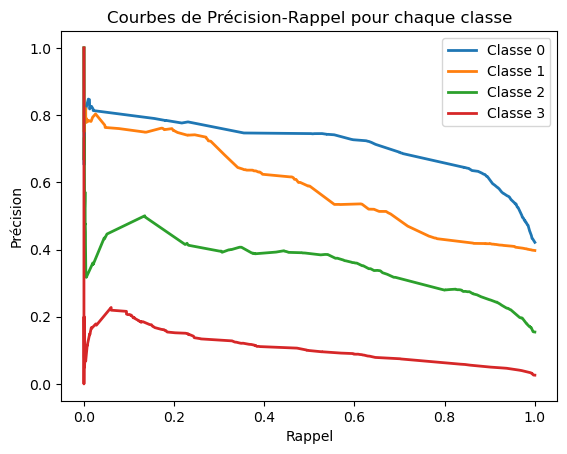

In [31]:
# Sur résultat XGBoostClassifier, tentative de modifier le seuil de décision
# Affichage des courbes précisoin / rappel pour chaque classe
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_scores = final_pipeline.predict_proba(x_test_pipeline)
# Binariser les labels de test pour OvR (one vs rest) nécessaire car precision_recall_curve ne supporte pas le multimodal
y_test_bin = label_binarize(y_test_pipeline, classes=[0, 1, 2, 3])

# Calculer et tracer les courbes de précision-rappel pour chaque classe
for i in range(y_scores.shape[1]):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, lw=2, label='Classe {}'.format(i))

plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.legend(loc='best')
plt.title('Courbes de Précision-Rappel pour chaque classe')
plt.show()

# La classe 3 qui nous intéresse ne peut être optimisé, la meilleur précision étant à peine à 0.2

In [32]:
# Test 6 - GradientBoostingClassifier (hyperparamètres par défaut pour estimer les résultats)
final_pipeline.set_params(classifier=GradientBoostingClassifier())

# Phase apprentissage

# Phase d'apprentissage sur train
final_pipeline.fit(x_train_pipeline, y_train_pipeline)

# Résultats sur train
y_train_pred = final_pipeline.predict(x_train_pipeline)
accuracy_train = accuracy_score(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])
report_train = classification_report(y_train_pipeline, y_train_pred)

print(f"Accuracy sur train : {accuracy_train}")
print(f"Confusion Matrix sur train :\n")
display(cm_train)
print(f"Classification Report sur train :\n{report_train}")

# Estimation du modèle sur test
y_test_pred = final_pipeline.predict(x_test_pipeline)
accuracy_test = accuracy_score(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['réelles'], colnames=['Prédites'])
report_test = classification_report(y_test_pipeline, y_test_pred)

y_test_prob = final_pipeline.predict_proba(x_test_pipeline)[:, 1]

print(f"Accuracy test : {accuracy_test}")
print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")

# Sauvegarde du modèle pour utilisation ultérieure
with open('streamlit_GradientBoosting_under_multi.pkl', 'wb') as model_file:
    pickle.dump(final_pipeline, model_file)





[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   8.7s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   6.0s
Accuracy sur train : 0.5437043111441099
Confusion Matrix sur train :



Prédites,0,1,2,3
Réelles,,,,
0,95071,8195,2722,8013
1,41505,33260,21299,12275
2,8329,5425,15405,12023
3,1304,684,1753,3454


Classification Report sur train :
              precision    recall  f1-score   support

           0       0.65      0.83      0.73    114001
           1       0.70      0.31      0.43    108339
           2       0.37      0.37      0.37     41182
           3       0.10      0.48      0.16      7195

    accuracy                           0.54    270717
   macro avg       0.46      0.50      0.42    270717
weighted avg       0.61      0.54      0.54    270717

Accuracy test : 0.5417345164113301
Confusion Matrix test :



Prédites,0,1,2,3
réelles,,,,
-1,40,26,1,19
0,31533,2792,887,2827
1,13633,11083,6998,4134
2,2822,1861,5195,4068
3,418,239,604,1093


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.65      0.83      0.73     38039
           1       0.69      0.31      0.43     35848
           2       0.38      0.37      0.38     13946
           3       0.09      0.46      0.15      2354

    accuracy                           0.54     90273
   macro avg       0.36      0.39      0.34     90273
weighted avg       0.61      0.54      0.54     90273



In [33]:
# ---------------------------------------------------
# Test 7 - Boosting  (maintien de RandomUnderSampler)
# ---------------------------------------------------
scorer = {'recall': make_scorer(recall_score, pos_label=3)}      # ne fonctionne pas
scorer = make_scorer(f1_score, average='macro')

params = [
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],  
        'preprocessor__Caractéristique__wcarac_dept__dropC' : [True],  
        'classifier' : [AdaBoostClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1.0]
     }]
grid = GridSearchCV(estimator=final_pipeline, param_grid=params, scoring=scorer, cv=3, refit=True)       #refit='recall')
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres AdaBoostClassifier : ", grid.best_params_)
print ("Avec un score de AdaBoostClassifier : ", grid.best_score_)

# Best estimator=learning_rate=0.1, n_estimators': 50
# Best score=

# RESULTATS
# ---------
# Prédiction et évaluation sur train
best_model = grid.best_estimator_
y_train_pred = best_model.predict(x_train_pipeline)
report_train = classification_report(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])

print(f"Confusion Matrix train :\n")
display(cm_train)
print(f"Classification Report train :\n{report_train}")


# Prédiction et évaluation sur test
best_model = grid.best_estimator_
y_test_pred = best_model.predict(x_test_pipeline)
report_test = classification_report(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['Réelles'], colnames=['Prédites'])

print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")

# Sauvegarde du modèle pour utilisation ultérieure
with open('streamlit_AdaBoost_under_multi.pkl', 'wb') as model_file:
    pickle.dump(final_pipeline, model_file)



[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.5s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.4s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.2s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.4s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.1s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.4s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.3s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipel

Prédites,0,1,2,3
Réelles,,,,
0,85355,15448,4646,8552
1,38390,35474,22838,11637
2,7310,6126,16599,11147
3,1149,763,2145,3138


Classification Report train :
              precision    recall  f1-score   support

           0       0.65      0.75      0.69    114001
           1       0.61      0.33      0.43    108339
           2       0.36      0.40      0.38     41182
           3       0.09      0.44      0.15      7195

    accuracy                           0.52    270717
   macro avg       0.43      0.48      0.41    270717
weighted avg       0.57      0.52      0.52    270717

Confusion Matrix test :



Prédites,0,1,2,3
Réelles,,,,
-1,0,59,18,9
0,28410,5098,1548,2983
1,12626,11784,7519,3919
2,2472,2147,5556,3771
3,373,267,729,985


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.65      0.75      0.69     38039
           1       0.61      0.33      0.43     35848
           2       0.36      0.40      0.38     13946
           3       0.08      0.42      0.14      2354

    accuracy                           0.52     90273
   macro avg       0.34      0.38      0.33     90273
weighted avg       0.57      0.52      0.52     90273



In [34]:
# ----------------------------------------------
# Test 8 - Boosting  (tests avec méthode SMOTE()
# ----------------------------------------------

scorer = {'recall': make_scorer(recall_score, pos_label=3)}      # ne fonctionne pas
scorer = make_scorer(f1_score, average='macro')

params = [
    {
        'preprocessor__Caractéristique__wcarac_com__dropC' : [True],  
        'preprocessor__Caractéristique__wcarac_dept__dropC' : [True],  
        'under' : [SMOTE(random_state=42)],
        'classifier' : [AdaBoostClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1.0]
     }]
grid = GridSearchCV(estimator=final_pipeline, param_grid=params, scoring=scorer, cv=3, refit=True)       #refit='recall')
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres AdaBoostClassifier : ", grid.best_params_)
print ("Avec un score de AdaBoostClassifier : ", grid.best_score_)

# Best estimator=n_estimators=100, earning_rate=1.0
# Best score=

# RESULTATS
# ---------
# Prédiction et évaluation sur train
best_model = grid.best_estimator_
y_train_pred = best_model.predict(x_train_pipeline)
report_train = classification_report(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])

print(f"Confusion Matrix train :\n")
display(cm_train)
print(f"Classification Report train :\n{report_train}")


# Prédiction et évaluation sur test
best_model = grid.best_estimator_
y_test_pred = best_model.predict(x_test_pipeline)
report_test = classification_report(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['Réelles'], colnames=['Prédites'])

print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")

# Sauvegarde du modèle pour utilisation ultérieure
with open('streamlit_AdaBoost_SMOTE_multi.pkl', 'wb') as model_file:
    pickle.dump(final_pipeline, model_file)



[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.9s
[Pipeline] ............. (step 2 of 4) Processing under, total=  41.8s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   2.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   8.3s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   6.1s
[Pipeline] ............. (step 2 of 4) Processing under, total=  51.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   1.6s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   8.4s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.8s
[Pipeline] ............. (step 2 of 4) Processing under, total=  42.9s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   1.8s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   7.5s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   5.2s
[Pipeline] ............. (step 2 of 4) Processing under, total=  41.5s
[Pipel

Prédites,0,1,2,3
Réelles,,,,
0,95222,9246,5161,4372
1,46401,31047,21118,9773
2,9164,8515,13096,10407
3,1329,955,2043,2868


Classification Report train :
              precision    recall  f1-score   support

           0       0.63      0.84      0.72    114001
           1       0.62      0.29      0.39    108339
           2       0.32      0.32      0.32     41182
           3       0.10      0.40      0.17      7195

    accuracy                           0.53    270717
   macro avg       0.42      0.46      0.40    270717
weighted avg       0.56      0.53      0.51    270717

Confusion Matrix test :



Prédites,0,1,2,3
Réelles,,,,
-1,62,8,11,5
0,31710,3026,1768,1535
1,15359,10180,7153,3156
2,3097,2931,4436,3482
3,442,310,689,913


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.63      0.83      0.71     38039
           1       0.62      0.28      0.39     35848
           2       0.32      0.32      0.32     13946
           3       0.10      0.39      0.16      2354

    accuracy                           0.52     90273
   macro avg       0.33      0.36      0.32     90273
weighted avg       0.56      0.52      0.51     90273



In [53]:
# ---------------------------------------------------------------------------
# Test 9 - Bagging + Decision Tree (tests avec méthode RANDOM UNDER SAMPLER()
# ---------------------------------------------------------------------------

scorer = {'recall': make_scorer(recall_score, pos_label=3)}      # ne fonctionne pas
scorer = make_scorer(f1_score, average='macro')

# Paramètres pour la recherche en grille
params = {
    'preprocessor__Caractéristique__wcarac_agg__encoder' : [None],
    'preprocessor__Caractéristique__wcarac_atm__encoder' : [None],
    'preprocessor__Caractéristique__wcarac_col__encoder' : [None],
    'preprocessor__Caractéristique__wcarac_dept__encoder' : [None],
    'preprocessor__Caractéristique__wcarac_lum__encoder' : [None],
    'preprocessor__Lieu__wlieu_catr__encoder' : [None],
    'preprocessor__Lieu__wlieu_circ__encoder' : [None],
    'preprocessor__Lieu__wlieu_plan__encoder' : [None],
    'preprocessor__Lieu__wlieu_situ__encoder' : [None],
    'preprocessor__Vehicule__wagg_catv_perso__encoder' : [None],
    'preprocessor__Vehicule__wvehi_choc__encoder' : [None],
    'preprocessor__Vehicule__wvehi_manv__encoder' : [None],
    'preprocessor__Vehicule__wvehi_motor__encoder' : [None],
    'preprocessor__Vehicule__wvehi_obs__encoder' : [None],
    'preprocessor__Vehicule__wvehi_obsm__encoder' : [None],
    'preprocessor__Usager__wuser_catu__encoder' : [None],
    'preprocessor__Usager__wuser_secu1__encoder' : [None],
    'preprocessor__Usager__wuser_secu2__encoder' : [None],
    'preprocessor__Usager__wuser_secu3__encoder' : [None],
    'preprocessor__Usager__wuser_trajet__encoder' : [None],
    "Selector__k" : ['all'],
    'preprocessor__Caractéristique__wcarac_com__dropC' : [True],  
    'preprocessor__Caractéristique__wcarac_dept__dropC' : [True],  
    'classifier' : [BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)],
    'classifier__n_estimators': [10, 50, 100],
    'classifier__base_estimator__max_depth': [3, 5, 7],
    'classifier__base_estimator__min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(estimator=final_pipeline, param_grid=params, scoring=scorer, cv=3, refit=True)       #refit='recall')
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres Bagging + DTree : ", grid.best_params_)
print ("Avec un score de Bagging + DTree : ", grid.best_score_)

# Best estimator=max_depth=7, n_estimators=100
# Best score=

# RESULTATS
# ---------
# Prédiction et évaluation sur train
bagging_under_multi_best_model = grid.best_estimator_
y_train_pred = bagging_under_multi_best_model.predict(x_train_pipeline)
report_train = classification_report(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])

print(f"Confusion Matrix train :\n")
display(cm_train)
print(f"Classification Report train :\n{report_train}")


# Prédiction et évaluation sur test
bagging_under_multi_best_model = grid.best_estimator_
y_test_pred = bagging_under_multi_best_model.predict(x_test_pipeline)
report_test = classification_report(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['Réelles'], colnames=['Prédites'])

print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")


# Sauvegarde du modèle pour utilisation ultérieure
with open('streamlit_Bagging_DTree_under_multi.pkl', 'wb') as model_file:
    pickle.dump(bagging_under_multi_best_model, model_file)


[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.4s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.4s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.9s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.4s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   6.4s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.3s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.1s
[Pipeline] ............. (step 2 of 4) Processing under, total=   0.1s
[Pipel

Prédites,0,1,2,3
Réelles,,,,
0,89651,13253,5097,6000
1,30983,43939,21010,12407
2,5481,6580,15965,13156
3,808,648,1566,4173


Classification Report train :
              precision    recall  f1-score   support

           0       0.71      0.79      0.74    114001
           1       0.68      0.41      0.51    108339
           2       0.37      0.39      0.38     41182
           3       0.12      0.58      0.19      7195

    accuracy                           0.57    270717
   macro avg       0.47      0.54      0.46    270717
weighted avg       0.63      0.57      0.58    270717

Confusion Matrix test :



Prédites,0,1,2,3
Réelles,,,,
-1,79,1,4,2
0,29831,4389,1718,2101
1,10304,14453,6930,4161
2,1902,2278,5317,4449
3,248,237,545,1324


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.70      0.78      0.74     38039
           1       0.68      0.40      0.51     35848
           2       0.37      0.38      0.37     13946
           3       0.11      0.56      0.18      2354

    accuracy                           0.56     90273
   macro avg       0.37      0.43      0.36     90273
weighted avg       0.62      0.56      0.58     90273



    Feature  Importance
10       10    0.182521
18       18    0.174763
2         2    0.099581
16       16    0.083526
1         1    0.074888
24       24    0.073832
15       15    0.072207
14       14    0.067975
17       17    0.052331
4         4    0.038262
6         6    0.018907
12       12    0.007880
9         9    0.007745
0         0    0.007452
13       13    0.006735
5         5    0.006266
11       11    0.005876
7         7    0.004218
3         3    0.002607
35       35    0.002553
20       20    0.002392
19       19    0.002028
8         8    0.001542
27       27    0.000937
32       32    0.000782
34       34    0.000470
36       36    0.000426
38       38    0.000331
26       26    0.000323
28       28    0.000165
33       33    0.000135
25       25    0.000107
22       22    0.000094
30       30    0.000079
21       21    0.000064
31       31    0.000000
29       29    0.000000
37       37    0.000000
23       23    0.000000
39       39    0.000000


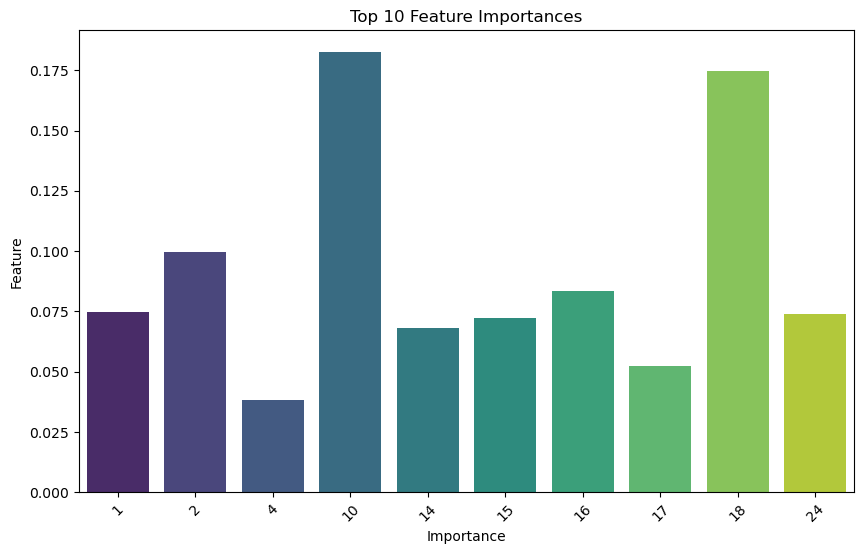

In [36]:
# Visualisation features les plus importantes (décision Tree)
bagging_model = grid.best_estimator_.named_steps['classifier']                # récupération du détail du modèle
X_train_transformed = grid.best_estimator_.named_steps['preprocessor'].transform(x_train_pipeline) # récupération du df_preprocessed

feature_importances = np.zeros(X_train_transformed.shape[1])
n_features = X_train_transformed.shape[1]

for tree in bagging_model.estimators_:
    if hasattr(tree, 'feature_importances_'):
        # Vérifier que les dimensions correspondent
        if len(tree.feature_importances_) == n_features:
            # Ajouter les importances des features
            feature_importances += tree.feature_importances_
        else:
            print(f"Tree with feature importances of shape {tree.feature_importances_.shape} skipped.")

# Moyenne des importances des features
feature_importances /= len(bagging_model.estimators_)

# Affichage de  l'importance de chaque feature
feature_importances_df = pd.DataFrame({
    'Feature': range(n_features),
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Affichage des 10 features les plus importantes
top_features = feature_importances_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.xticks(rotation=45)  # Remplacer 45 par l'angle désiré
plt.ylabel('Feature')
plt.show()

In [37]:
bagging_model = grid.best_estimator_.named_steps['classifier'].estimators_
bagging_model

[DecisionTreeClassifier(max_depth=7, min_samples_split=5,
                        random_state=1952926171),
 DecisionTreeClassifier(max_depth=7, min_samples_split=5,
                        random_state=1761383086),
 DecisionTreeClassifier(max_depth=7, min_samples_split=5,
                        random_state=1449071958),
 DecisionTreeClassifier(max_depth=7, min_samples_split=5,
                        random_state=1910541088),
 DecisionTreeClassifier(max_depth=7, min_samples_split=5,
                        random_state=1341730541),
 DecisionTreeClassifier(max_depth=7, min_samples_split=5,
                        random_state=1286572245),
 DecisionTreeClassifier(max_depth=7, min_samples_split=5,
                        random_state=1005142668),
 DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=502852014),
 DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=186414760),
 DecisionTreeClassifier(max_depth=7, min_samples_split=5,
                    

In [54]:
# ------------------------------------------------------------
# Test 10 - Bagging + Decision Tree (tests avec méthode SMOTE()
# ------------------------------------------------------------

scorer = {'recall': make_scorer(recall_score, pos_label=3)}      # ne fonctionne pas
scorer = make_scorer(f1_score, average='macro')

# Paramètres pour la recherche en grille
params = {
    'preprocessor__Caractéristique__wcarac_com__dropC' : [True],  
    'preprocessor__Caractéristique__wcarac_dept__dropC' : [True],  
    'under' : [SMOTE(random_state=42)],
    'classifier' : [BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)],
    'classifier__n_estimators': [10, 50, 100],
    'classifier__base_estimator__max_depth': [3, 5, 7],
    'classifier__base_estimator__min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(estimator=final_pipeline, param_grid=params, scoring=scorer, cv=3, refit=True)       #refit='recall')
grid.fit(x_train_pipeline, y_train_pipeline)
print ("Meilleurs paramètres BaggingClassifier : ", grid.best_params_)
print ("Avec un score de BaggingClassifier : ", grid.best_score_)

# Best estimator=max_depth': 7, min_samples_split': 2, n_estimators': 50, 
# Best score=

# RESULTATS
# ---------
# Prédiction et évaluation sur train
bagging_SMOTE_multi_best_model = grid.best_estimator_
y_train_pred = bagging_SMOTE_multi_best_model.predict(x_train_pipeline)
report_train = classification_report(y_train_pipeline, y_train_pred)
cm_train = pd.crosstab(y_train_pipeline, y_train_pred, rownames=['Réelles'], colnames=['Prédites'])

print(f"Confusion Matrix train :\n")
display(cm_train)
print(f"Classification Report train :\n{report_train}")


# Prédiction et évaluation sur test
bagging_SMOTE_multi_best_model = grid.best_estimator_
y_test_pred = bagging_SMOTE_multi_best_model.predict(x_test_pipeline)
report_test = classification_report(y_test_pipeline, y_test_pred)
cm_test = pd.crosstab(y_test_pipeline, y_test_pred, rownames=['Réelles'], colnames=['Prédites'])

print(f"Confusion Matrix test :\n")
display(cm_test)
print(f"Classification Report test :\n{report_test}")

# Sauvegarde du modèle pour utilisation ultérieure
with open('streamlit_Bagging_DTree_SMOTE_multi.pkl', 'wb') as model_file:
    pickle.dump(bagging_SMOTE_multi_best_model, model_file)


[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=  11.2s
[Pipeline] ............. (step 2 of 4) Processing under, total= 1.4min
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   5.7s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   2.3s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   4.5s
[Pipeline] ............. (step 2 of 4) Processing under, total= 1.3min
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   5.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   5.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=  11.1s
[Pipeline] ............. (step 2 of 4) Processing under, total=  53.8s
[Pipeline] .......... (step 3 of 4) Processing Selector, total=   3.2s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.9s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   6.5s
[Pipeline] ............. (step 2 of 4) Processing under, total= 1.0min
[Pipel

Prédites,0,1,2,3
Réelles,,,,
0,86767,6344,3518,17372
1,35485,35358,20379,17117
2,4417,7012,15142,14611
3,579,853,1883,3880


Classification Report train :
              precision    recall  f1-score   support

           0       0.68      0.76      0.72    114001
           1       0.71      0.33      0.45    108339
           2       0.37      0.37      0.37     41182
           3       0.07      0.54      0.13      7195

    accuracy                           0.52    270717
   macro avg       0.46      0.50      0.42    270717
weighted avg       0.63      0.52      0.54    270717

Confusion Matrix test :



Prédites,0,1,2,3
Réelles,,,,
-1,50,17,8,11
0,28789,2080,1171,5999
1,11712,11752,6734,5650
2,1489,2429,5043,4985
3,194,304,648,1208


Classification Report test :
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.68      0.76      0.72     38039
           1       0.71      0.33      0.45     35848
           2       0.37      0.36      0.37     13946
           3       0.07      0.51      0.12      2354

    accuracy                           0.52     90273
   macro avg       0.37      0.39      0.33     90273
weighted avg       0.63      0.52      0.54     90273



## Clusterisation des zones = f(coordonnées GPS)

In [39]:
# Test de clusterisation des coordonnées gps --> générer des zones géographique plutôt que d'exclure les datas
x_train_pipeline_lat = x_train_pipeline['carac_gps_lat']
x_train_pipeline_long = x_train_pipeline['carac_gps_long']

# On définit tous nos points à classifier

X_coordonnees = np.array((list(zip(x_train_pipeline['carac_gps_lat'], x_train_pipeline['carac_gps_long']))))

# Clusterisation avec Kmeans 
kmean_zones = KMeans(n_clusters=20, random_state=0)
kmean_zones.fit(X_coordonnees)

#zones = pd.Series(kmean_zones.labels_)
zones = kmean_zones.labels_
x_train_pipeline['zone_geographique'] = np.nan_to_num(zones, nan=0)

# Par la suite, il faudrait inclure cette étape dans le pipeline si les résultats sont satisfaisant


In [40]:
x_train_pipeline['zone_geographique'].value_counts()
kmean_zones.labels_

array([10, 10, 10, ...,  7,  7,  7], dtype=int32)

In [42]:
# Afficher les zones obtenues

# Calculer le centre de la carte
center_lat = x_train_pipeline['carac_gps_lat'].mean()
center_long = x_train_pipeline['carac_gps_long'].mean()

# Créer une carte centrée sur les coordonnées moyennes
map = folium.Map(location=[center_lat, center_long], zoom_start=6)

# Définir une palette de couleurs pour les clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 
          'gray', 'black', 'lightgray', 'yellow']

# Ajouter les points à la carte
for _, row in x_train_pipeline.iterrows():
    folium.CircleMarker(
        location=[row['carac_gps_lat'], row['carac_gps_long']],
        radius=5,
        color=colors[int(row['zone_geographique'])],
        fill=True,
        fill_color=colors[int(row['zone_geographique'])],
        fill_opacity=0.7
    ).add_to(map)

# Afficher la carte
map.save('map_clusters.html')
map

"\n# Calculer le centre de la carte\ncenter_lat = x_train_pipeline['carac_gps_lat'].mean()\ncenter_long = x_train_pipeline['carac_gps_long'].mean()\n\n# Créer une carte centrée sur les coordonnées moyennes\nmap = folium.Map(location=[center_lat, center_long], zoom_start=6)\n\n# Définir une palette de couleurs pour les clusters\ncolors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', \n          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', \n          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', \n          'gray', 'black', 'lightgray', 'yellow']\n\n# Ajouter les points à la carte\nfor _, row in x_train_pipeline.iterrows():\n    folium.CircleMarker(\n        location=[row['carac_gps_lat'], row['carac_gps_long']],\n        radius=5,\n        color=colors[int(row['zone_geographique'])],\n        fill=True,\n        fill_color=colors[int(row['zone_geographique'])],\n        fill_opacity=0.7\n    ).add_to(map)\n\n# Afficher la carte\nmap.save('map_cluster